# CS146 Problem Set 2: Analytical approximations

* Complete all the problems below.
* Show and explain your work in detail.
* **Edit and submit this Jupyter notebook.** Do not upload only a PDF. Your instructor needs the notebook to run your code and check that it correctly reproduces your results.
* **Do not use ChatGPT** or similar AI tools in this assignment.
* **Learning outcomes:** #cs146-AnalyticalApproximation, #cs114-ModelSelection, #modeling (optional), #composition, #professionalism

## Overview

In this problem set, we revisit the polynomial linear regression models from Session 10. We fit polynomials of various degrees to the data set below. You might find it helpful to revisit the pre-class and breakout workbooks from that class to review the work we did there. The data set used here is different from the ones used in class.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


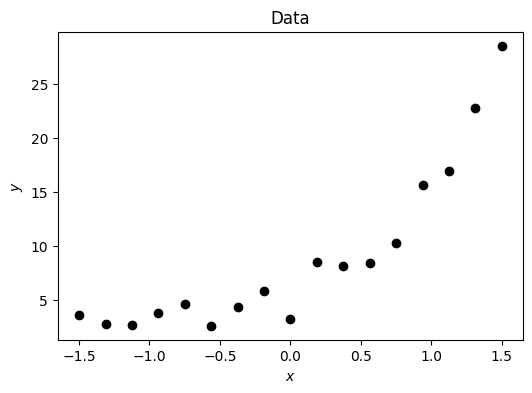

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm


data_x = np.array([-1.500, -1.312, -1.125, -0.938, -0.750, -0.562, -0.375, -0.188, 0.000, 0.188, 0.375, 0.562, 0.750, 0.938, 1.125, 1.312, 1.500])
data_y = np.array([3.571, 2.777, 2.697, 3.749, 4.669, 2.618, 4.312, 5.833, 3.276, 8.461, 8.108, 8.412, 10.262, 15.631, 16.960, 22.713, 28.491])

plt.figure(figsize=(6, 4))
plt.title('Data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(data_x, data_y, 'ko')
plt.show()

The polynomial models all have a likelihood function of the form

$$y_i = \text{Normal}(\mu_i, \sigma^2)$$

$$\mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + \cdots + \beta_k x_i^k$$

where $k$ is the degree of the polynomial.

In [5]:
def make_model(degree):
    # Make a polynomial model with the given degree in PyMC
    with pm.Model() as model:
        # Data
        x = pm.MutableData('x', data_x)
        # Noise scale
        sigma = pm.LogNormal('sigma', mu=0, sigma=1)
        # Constant term
        alpha = pm.Normal('alpha', mu=0, sigma=1)
        # Coefficients of the x^i terms
        beta = pm.Normal('beta', size=degree, mu=0, sigma=1)
        # Compute the mean of the polynomial given the alpha and beta coefficients
        mu = alpha
        for i in range(1, degree + 1):
            mu = mu + beta[i-1] * x ** i
        mu = pm.Deterministic('mu', mu)
        # Likelihood
        y = pm.Normal('y', mu=mu, sigma=sigma, observed=data_y)
    return model

cubic_model = make_model(3)
#pm.model_to_graphviz(cubic_model) -> does not work for me 

## Problem 1: Estimating model evidence

The goal of the activity in Session 10 was to understand how the _model evidence_ (the denominator in Bayes’ equation, also known as the _marginal likelihood_) helps us to select the best model or models from a collection of models. We used function fitting in PyMC to estimate the model evidence for various polynomial degrees. The code for doing this is provided in Problem 2 below.

Explain why it is possible to use a function-fitting algorithm to estimate the model evidence. You may explain this with reference to the function-fitting algorithm used in PyMC (ADVI) or with reference to the function-fitting algorithm we explored in Sessions 22 and 23 (the Laplace approximation). The answers are somewhat different in those two cases however, you should address the same question in either case — how can we use the algorithm to estimate model evidence?

* Explain why it is possible conceptually.
* Provide the basic mathematical detail for where the model evidence shows up in the function-fitting algorithm.
* (You do not actually have to compute the model evidence here. We will do this in Problem 2.)

## Answer

The posterior distribution is given by Bayes' theorem:

$p(\theta | D) = \frac{p(D)}{p(D | \theta) \cdot p(\theta)}$


The model evidence p(D) is the marginal likelihood, representing the probability of observing the data across all possible parameter values. It is calculated as the integral of the likelihood function multiplied by the prior over the parameter space:

$p(D) = \int p(D | \theta) \cdot p(\theta) \, d\theta$


As we can see,  computing model evidence requires taking integrals over a range of possible parameters. It is very complex and computationally difficult (if not impossible sometimes) to compute. Since model evidence is an integral part of Bayes's theorem, we need it to get the posterior. Therefore, we use function-fitting algorithms to estimate the model parameters θ that best describe the observed data D

## Laplace approximation

Laplace approximation facilitates the estimation of the model evidence by providing a Gaussian approximation to the posterior.

The reason why we can estimate the model evidence with Laplace approximation is the central limit theorem. 
We usually want to use the Laplace approximation often when we need to make Bayesian inference tractable, especially in situations where analytical solutions are challenging to get. This method allows us to capture the essential features of the posterior distribution while simplifying complex calculations.

The Central Limit Theorem (CLT) states that the sum or average of a large number of independent and identically distributed random variables tends to follow a Gaussian distribution. 

 Mathematically, for a sample mean X of n independent random variables Xi, each with mean μ and standard deviation σ

$$
\sqrt{n} \left( \frac{\bar{X}_n - \mu}{\sigma} \right) \rightarrow N(0,1)
$$


The posterior distribution combines the likelihood function (which describes how well the model explains the data) and the prior distribution (which represents our beliefs about the parameters before observing data). When we have a large sample size, the likelihood component dominates the posterior distribution due to the increasing influence of the observed data. If the likelihood function is well-behaved and has certain regularity conditions, the posterior distribution starts to have properties of a normal distribution. Well behaved means that the function has have well-defined derivatives and does not have abrupt changes or discontinuities. It is continuous across its domain. It should have a single peak or mode, indicating a clear point of maximum likelihood. Regularity conditions: differentiability (we can find the first and second order derivatives needed for analysis), mean and variance should be finite. This condition is necessary for the Central Limit Theorem to apply. The model should be identifiable, meaning that distinct parameter values correspond to different distributions. This condition ensures that parameters can be estimated.

Therefore, as the sample size (n) increases, the posterior distribution becomes asymptotically normal due to the CLT, assuming a well-behaved likelihood. The posterior distribution p(θ∣D) approaches a normal distribution:

$ p(\theta|D) \xrightarrow{n \to \infty} N(\mu_{\text{post}}, \Sigma_{\text{post}}) $



The Laplace approximation focuses on the mode of the posterior distribution, which corresponds to the maximum a posteriori (MAP) estimate. MAP represents the values of the parameters that maximize the posterior distribution, which is the product of the likelihood and the prior distribution, normalized by the evidence (marginal likelihood).

The mode MAPθ is obtained by solving the equation

$\nabla \log p(\theta|D) = 0$


We find the peak (maximum) of the unnormalized log posterior distribution. Log distribution is chosen because it behaves much better numerically. The logarithm is a monotonic transformation, so the location of the maximum in the log scale corresponds to the location of the maximum in the original scale. Mathematically, the log posterior is given by

$\log p(\theta|D) = \log p(D|\theta) + \log p(\theta) - \log p(D)$


We approximate the maximum by finding the peak of log posterior. To do so we set the first order derivative (gradient) of the log posterior to zero. Setting the first order derivative to zero gives us the point where the slope of the curve of the function is zero, thus flat.

$\nabla \log p(\theta|D) = 0$


Usually, it would signify the maximum/minimum or a saddle point. Since we use the normal distribution, we know its shape and we know that the critical point we find with the first order derivative is the peak (max) of the distribution.

After finding the critical point, we use the second-order derivative (Hessian matrix) to assess the curvature of the log posterior at that point. The Hessian matrix is a square matrix of second-order partial derivatives of the log posterior with respect to its parameters. For a univariate function, it is a scalar (second derivative). For a multivariate function with parameters θ, the Hessian matrix is an n×n matrix, where n is the number of parameters.

For a univariate function f(θ):
\[ H = \begin{bmatrix} \frac{\partial^2 f}{\partial \theta^2} \end{bmatrix} 

For a multivariate function f(θ1, θ2, ..., θn):
\[ H = \begin{bmatrix} \frac{\partial^2 f}{\partial \theta_1^2} & \frac{\partial^2 f}{\partial \theta_1 \partial \theta_2} & \ldots & \frac{\partial^2 f}{\partial \theta_1 \partial \theta_n} \\ \frac{\partial^2 f}{\partial \theta_2 \partial \theta_1} & \frac{\partial^2 f}{\partial \theta_2^2} & \ldots & \frac{\partial^2 f}{\partial \theta_2 \partial \theta_n} \\ \vdots & \vdots & \ddots & \vdots \\ \frac{\partial^2 f}{\partial \theta_n \partial \theta_1} & \frac{\partial^2 f}{\partial \theta_n \partial \theta_2} & \ldots & \frac{\partial^2 f}{\partial \theta_n^2} \end{bmatrix} 


The inverse of the negative Hessian matrix is proportional to the covariance matrix of a multivariate Gaussian distribution. The diagonal elements of the inverse Hessian matrix represent the variances of the parameters. If we use only diagonals, it is a mean field approximation; if we use the whole matrix, it is a full rank approximation, which accounts for the covariance between the parameters. Mean field is faster and easier to do than the full rank since it scales linearly with the number of parameters, while full rank scales quadratically. When choosing between the mean field and full rank we should account for the probability of the high influence of the covariances. 

In a multivariate context, the standard deviations of each parameter are given by the square root of the corresponding diagonal elements of the inverse Hessian matrix. In the case of a multivariate Gaussian distribution with covariance matrix Σ these standard deviations are related to the diagonal elements of Σ^(-1)

$$\sigma_i = \sqrt{(\Sigma^{-1})_{ii}}$$


For a univariate (1 parameter) function, the standard deviation (σ) is proportional to $$ \frac{1}{\sqrt{-H}} $$

The model evidence acts as a normalization constant, ensuring that the posterior distribution integrates to one. In the Laplace approximation, the Gaussian form provides a scaled and normalized posterior representation. 

### ADVI

ADVI stands for Automatic Differentiation Variational Inference. ADVI optimizes a parametric model to approximate the posterior distribution. Maximizing the ELBO during this process indirectly provides an estimate of the log marginal likelihood or model evidence.

Variational difference (VI) is the process in the core of ADVI. We use it to approximate complex probability distributions by finding a simpler distribution, known as the variational distribution q(θ), close to the true and often intractable posterior p(θ∣D).

The variational difference is optimized by minimizing the difference between the true posterior and the variational distribution. We use Kullback-Leibler (KL) divergence to measure the difference between the 2 distributions. Let's denote P(θ) as the true posterior and Q(θ) as the variational distribution. The KL divergence between two probability distributions, P and Q is defined as:

$$
\text{KL}(P || Q) = \int P(\theta) \log\left(\frac{Q(\theta)}{P(\theta)}\right) d\theta
$$


The expression involves integrating over the entire parameter space θ, which represents all possible values of the parameter. The logarithm of the ratio P(θ)/ Q(θ) is taken. This ratio represents how much more or less likely an event θ is under the distribution Q compared to P. The result is then multiplied by the true distribution P(θ). This weighting ensures that the divergence is higher for regions of θ where the true distribution P(θ) assigns a higher probability. The entire expression is integrated over θ, summing up the weighted logarithmic differences across all possible values of the parameter.

However, in ADVI algorithm we directly maximize evidence lower bound (ELBO) instead of KL divergence. Directly maximizing the ELBO is computationally more efficient than explicitly minimizing the KL divergence. However, the main reason is that sometimes the true posterior distribution is not available in closed form, making the direct minimization of KL divergence challenging. The ELBO involves expectations, precisely the expectation of the log joint probability of the observed data and the model parameters under the variational distribution. Because it is expressed as an expectation, ELBO is often computationally tractable even when a closed-form solution for the true posterior is not available.

So, the objective function of ADVI is defined in terms of the Evidence Lower Bound (ELBO). The variational parameters are denoted by ϕ, and the goal is to find the values of ϕ that maximize the ELBO.

$$
\text{ELBO}(\phi) = \mathbb{E}_{q(\theta | \phi)} [\log p(D, \theta) - \log q(\theta | \phi)]
$$


E q(θ∣ϕ)represents the expectation operator. In the context of variational inference, it denotes the expectation taken with respect to the variational distribution q(θ∣ϕ). It represents averaging over different values of θ according to the variational distribution. 
logp(D,θ) represents how well the model explains the observed data since it is is the logarithm of the joint probability of the observed data D and the model parameters θ. 
−logq(θ∣ϕ)is the negative logarithm of the variational distribution (θ∣ϕ). It represents the "cost" of using the variational distribution to approximate the true posterior. Minimizing this term encourages the variational distribution to be close to the true posterior.

Stochastic (random sample-based) gradient-ascent algorithm is commonly used to find the values of ϕ that maximize the ELBO.The gradient of the ELBO with respect to the variational parameters ∇ϕELBO is calculated using the chain rule of calculus. The chain rule decomposes the gradient with respect to ϕ into a product of partial derivatives:

$$
\nabla_{\phi} \text{ELBO} = \frac{\partial \text{ELBO}}{\partial \phi_1} \frac{\partial \phi_1}{\partial \phi_2} \ldots \frac{\partial \phi_{n-1}}{\partial \phi_n}
$$


The first term represents the partial derivative of the ELBO with respect to the i-th variational parameter. It indicates how a small change in ϕi would affect the ELBO.
Next terms represent the partial derivatives of one variational parameter with respect to the next. They indicate how changes in one parameter influence another in the sequence.
The optimization process updates the variational parameters until convergence.

Once the optimization process converges, the variational parameters are set to values that maximize ELBO. ELBO is a lower bound on the log model evidence, so it is maximized to tighten this lower bound and offer a close approximation to the true log model evidence. Given that optimization algorithms typically minimize functions, it is common to minimize the negative of the ELBO (−ELBO), which is the mathematical equivalent to maximizing the ELBO. This minimization gives us a practical estimate of the negative log model evidence, encompassing both the likelihood term and addressing the intractable marginal likelihood. The resulting variational distribution q(θ), derived from the optimized parameters, approximates the true posterior distribution of model parameters. Using this distribution allows for inferences about the model parameters, while the estimated model evidence (−ELBO) is usually used as a practical measure for model comparison.

### (Optional) Problem 1b: Compare ADVI and the Laplace approximation

Explain how model evidence is computed in _both_ function-fitting algorithms. The two algorithms will give different answers. Highlight the pros and cons of estimating model evidence using each of the algorithms.

**This is a challenging problem.** Excellent (correct, detailed, well-explained) answers will get an extra ⑤ on the #cs146-AnalyticalApproximation LO. There is no penalty for not completing this problem or for getting it wrong.

I explained how the model evidence is computed in both function-fitting algorithms above; here I will compare them and highlight the pros and cons of estimating model evidence using each of the algorithms.

### ADVI 

#### Pros

ADVI is often more scalable to large datasets and high-dimensional models. It allows for flexible families of variational distributions, accommodating complex posterior shapes. ADVI uses automatic differentiation, making it easy to compute gradients and handle complex models. The ELBO, which is maximized during ADVI, is a lower bound on the log model evidence. Maximizing the ELBO during ADVI provides a computationally tractable way to obtain an approximation of the log model evidence, making it useful for model comparison.

#### Cons

The ELBO is still a lower bound and might not be as tight as desired. The reasons for that is sensitivity to initialization and possible convergence challenges that can impact the accuracy of the estimated model evidence.

The optimization process in ADVI can be sensitive to the choice of initialization and finding appropriate initial values. Different initial values may lead to different local optima or impact convergence speed. This sensitivity makes it challenging to find a set of initial values that consistently result in the desired outcome.

Also, we need to monitor convergence and ensure that ADVI reaches a stable state solution; otherwise, the results will not be reliable. Achieving convergence is especially challenging when we have an uneven surface of the parameter space with constrained variables that result in sharp cuts of the posterior parameter space. In that case, reparametrization is necessary. 

The need for experimentation with initialization and monitoring convergence increases computational cost, making ADVI less efficient than methods with more robust convergence properties. The increased computational requirements might limit the practicality of ADVI, especially in scenarios where computational resources are constrained.

### Laplace

#### Pros

In general, the Laplace approach is more simple than ADVI. The simplicity of the method makes it accessible and easy to implement

Laplace approximation provides a deterministic solution, making it more straightforward to understand and interpret. It directly yields a single set of parameter values, which can be beneficial for straightforward analysis.

Compared to ADVI, Laplace approximation is often less sensitive to the choice of initialization, which makes it a more convenient choice, especially when dealing with models where finding appropriate initial values can be challenging.

Laplace approximation assumes that the posterior distribution is Gaussian. While this assumption may not hold in all cases, the Gaussian assumption simplifies the optimization process and leads to a closed-form solution for certain models and situations. It is particularly effective when the posterior distribution is unimodal and symmetric.

#### Cons

Gaussian assumption, which is at the core of this method, might be a disadvantage in some cases. While it simplifies the process a lot, it also means that the approach will not be applicable to all models, especially those with highly non-Gaussian or multi-modal posterior distributions. In those cases, Laplace mehtod will just not be able to capture the true posterior distribution. It also may not scale well to high-dimensional problems.

### Conclusion: Laplace vs ADVI

ADVI is advantageous for scalability and flexibility, especially in high-dimensional and complex scenarios. Laplace approximation is preferred for its simplicity and deterministic nature but may be limited by its Gaussian assumption and less scalability.

## Problem 2: Was using mean-field a good idea?

The code below was used to determine the best degree of a polynomial for the data set above. Should it be linear, quadratic, etc.?

In Session 23, we learned that using a mean-field approximation is not necessarily a good idea when fitting a Multivariate Normal to a posterior since it cannot represent correlations between variables. PyMC uses the mean-field approximation by default.

Your task is to analyze the impact of using the mean-field approximation _versus_ the full-rank approximation.

Finished [100%]: Average Loss = 69.5
Finished [100%]: Average Loss = 68.13
Finished [100%]: Average Loss = 64.226
Finished [100%]: Average Loss = 60.168
Finished [100%]: Average Loss = 60.282
Finished [100%]: Average Loss = 61.276
Finished [100%]: Average Loss = 63.085


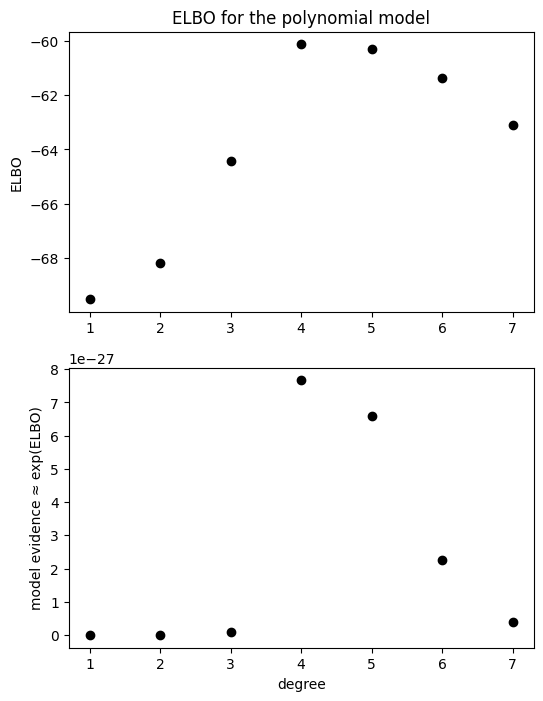

In [11]:
# Store the PyMC models, the function fits (approximations), and estimates
# of the ELBO produced by the function fitting algorithm
models_mean_field = []
approximations_mean_field = []
elbos_mean_field  = []

# Create the models and compute the ELBOs for polynomial degrees 1–7
degrees = range(1, 8)
for degree in degrees:
    model = make_model(degree)
    with model:
        approx = pm.fit(100000, progressbar=False)
    models_mean_field.append(model)
    approximations_mean_field.append(approx)
    elbos_mean_field.append(-np.mean(approx.hist[-10000:]))

# Plot the results
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.title('ELBO for the polynomial model')
plt.plot(degrees, elbos_mean_field, 'ko')
plt.ylabel('ELBO')
plt.subplot(2, 1, 2)
plt.plot(degrees, np.exp(elbos_mean_field), 'ko')
plt.xlabel('degree')
plt.ylabel('model evidence ≈ exp(ELBO)')
plt.show()

Do all of the following.

* Rerun this code using the full-rank ADVI algorithm and record the evidence lower bound (ELBO) values. The ELBO values are approximations of the log of the model evidence.
* How much worse is the mean-field approximation than the full-rank approximation? Quantify your answer to this question and explain your work.
* Do any of our conclusions change about which degrees are better or worse than others?

### Running the code with full rank ADVI algorithm

Finished [100%]: Average Loss = 69.37
Finished [100%]: Average Loss = 67.811
Finished [100%]: Average Loss = 63.735
Finished [100%]: Average Loss = 58.13
Finished [100%]: Average Loss = 57.957
Finished [100%]: Average Loss = 58.694
Finished [100%]: Average Loss = 59.594


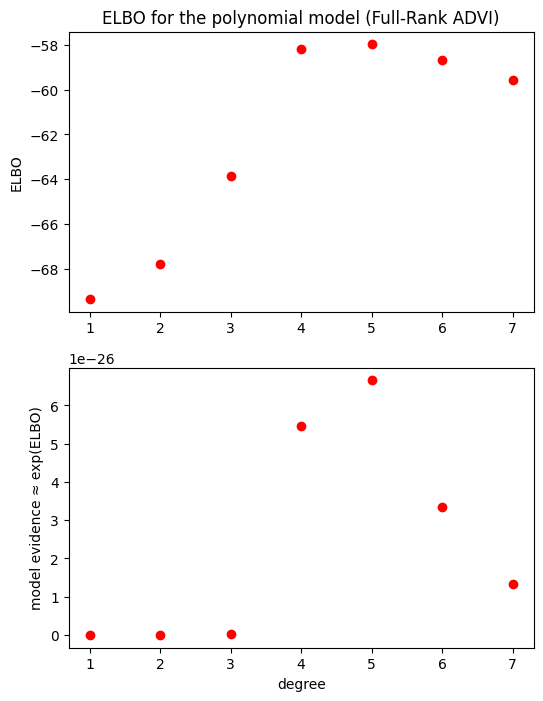

In [24]:
# Store the PyMC models, the function fits (approximations), and estimates
# of the ELBO produced by the function fitting algorithm
models_full_rank = []
approximations_full_rank = []
elbos_full_rank = []

# Create the models and compute the ELBOs for polynomial degrees 1–7
degrees = range(1, 8)
for degree in degrees:
    model = make_model(degree)
    with model:
        # Use the full-rank algorithm
        approx = pm.fit(100000, progressbar=False, method = 'fullrank_advi')
    models_full_rank.append(model)
    approximations_full_rank.append(approx)
    elbos_full_rank.append(-np.mean(approx.hist[-10000:]))
    

# Plot the results
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.title('ELBO for the polynomial model (Full-Rank ADVI)')
plt.plot(degrees, elbos_full_rank, 'ro')
plt.ylabel('ELBO')
plt.subplot(2, 1, 2)
plt.plot(degrees, np.exp(elbos_full_rank), 'ro')
plt.xlabel('degree')
plt.ylabel('model evidence ≈ exp(ELBO)')
plt.show()


### Visual comparison Full Rank vs Mean Field

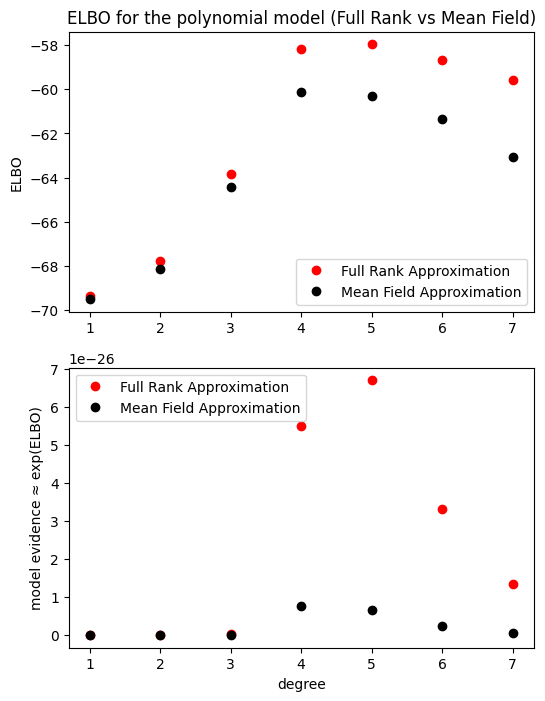

In [23]:
plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
plt.title('ELBO for the polynomial model (Full Rank vs Mean Field)')
plt.plot(degrees, elbos_full_rank, 'ro', label='Full Rank Approximation')
plt.plot(degrees, elbos_mean_field, 'ko', label='Mean Field Approximation')
plt.legend()
plt.ylabel('ELBO')

plt.subplot(2, 1, 2)
plt.plot(degrees, np.exp(elbos_full_rank), 'ro', label='Full Rank Approximation')
plt.plot(degrees, np.exp(elbos_mean_field), 'ko', label='Mean Field Approximation')
plt.legend()
plt.xlabel('degree')
plt.ylabel('model evidence ≈ exp(ELBO)')
plt.show()

### Quantitative Comparison Mean Field vs Full Rank

In [51]:
def elbo_difference(degree,elbo_full_rank,elbo_mean_field):
    difference = []
    for degree, elbo_full_rank, elbo_mean_field in zip(degrees, final_elbo_full_rank, final_elbo_mean_field):
        diff = elbo_full_rank - elbo_mean_field
        difference.append(diff)
        print(f"degree {degree}:")
        print(f"full rank: {elbo_full_rank}")
        print(f"mean field: {elbo_mean_field}")
        print(f"ELBO difference: {diff}\n")
    return difference 
    

In [52]:
difference = elbo_difference(degree,elbo_full_rank,elbo_mean_field)

degree 1:
full rank: -69.35860344380922
mean field: -69.50546497314137
ELBO difference: 0.14686152933215624

degree 2:
full rank: -67.79248950131466
mean field: -68.16605723435981
ELBO difference: 0.37356773304514945

degree 3:
full rank: -63.84500236650993
mean field: -64.43580214913653
ELBO difference: 0.590799782626604

degree 4:
full rank: -58.16999965079445
mean field: -60.13345875445747
ELBO difference: 1.9634591036630198

degree 5:
full rank: -57.97230749231424
mean field: -60.28472436403222
ELBO difference: 2.3124168717179785

degree 6:
full rank: -58.6619261958479
mean field: -61.35643600953773
ELBO difference: 2.6945098136898338

degree 7:
full rank: -59.573694747502465
mean field: -63.08419168599279
ELBO difference: 3.510496938490327



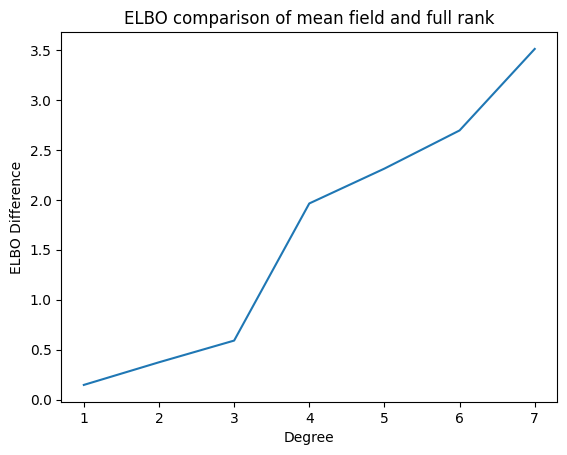

Average ELBO Difference: 1.6560159675092956


In [46]:
plt.plot(range(1, len(difference) + 1), difference)
plt.title('ELBO comparison of mean field and full rank')
plt.ylabel('ELBO Difference')
plt.xlabel('Degree')
plt.show()

average_difference = np.mean(difference)
print(f"Average ELBO Difference: {average_difference}")

The ELBO Difference represents how much worse Mean-Field ADVI is compared to Full-Rank ADVI for each degree.
The difference is relatively small for lower-degree polynomials (degree 1), while for higher-degree polynomials (degree 7), the difference becomes more significant. So, we can observe that as the degree of the polynomial increases, the ELBO difference generally becomes larger, indicating that the mean field approximation becomes progressively worse relative to the full rank approximation. This results suggest that, in this particular context, the full rank ADVI tends to provide better approximations to the true posterior than the mean field, especially for more complex models. The reason for that is that full rank is better in capturing the covariance among parameters. In contrast, mean-field assumes independence between parameters, which can be a limitation when the true posterior involves dependencies. This aligns with the idea that as the model complexity increases, the limitations of mean field approximations become more apparent. At the same time, full rank can better handle the complex posterior distributions by effectively capturing covariances between the increasing number of parameters.

### Model comparison

Lower ELBO is preferred since it indicates a better fit. 

Mean field provides a lower ELBO value (-60.13) for a model with degree 4 compared to other models. According to the mean field, the second best model is a degree 5 model with ELBO of (-60.28). Therefore, according to the mean field, we should choose model 4 as the best. 

However, according to the full rank, the lowest ELBO value is one of the models with 5 degrees (-57.97), while the model with 4 degrees has a value of (-58.16), which suggests the better performance of the model with 5 degrees.

Mean field assumes that the posterior distribution factorizes into independent distributions for each parameter, ignoring potential correlations. This assumption simplifies computations but may lead to an oversimplified representation of the posterior. However, full rank captures more complexity of the posterior distribution by considering correlations between parameters, which allows it to explore a larger part of the parameter space. Thus, it is considered more accurate in this context. 

Using full rank algorithm provides us with additional insight and makes us reconsider the previous choice of model with 4 degrees and opt for the model with 5 degrees.

## AI tools

I used Grammarly to proofread my writing, and I used GPT to get the latex of the equations I needed. 

## (Optional) Problem 3. Discrete Fourier Transform basis functions

Instead of fitting polynomial basis functions to the given data set, we fit trigonometric basis functions.

A polynomial function of degree $n$ can be written as a sum of monomial basis functions

$$f(x) = \sum_{j = 0}^n c_j x^j$$

We can also write a function as a sum of Discrete Fourier Transform (DFT) basis functions

$$f(x) = \sum_{j = 0}^{n-1} a_j \sin (jx) + b_j \cos (jx) $$

where $j$ is the frequency of a basis function.

**Background information:**  The DFT is used extensively in digital signal processing. For example, audio MP3s, JPEG images, and various video formats are compressed using the DFT as part of the compression algorithm. Usually, the DFT takes $n$ equal to the number of samples in the digital signal. However, we can approximate a signal by reducing $n$ — that is, by using only the first $n$ frequencies in the signal.

**Tasks:**

* Use the same data set we used for polynomial linear regression above.
* Read up as much as you need to about the DFT so you can explain your work clearly in this problem. (Feel free to use ChatGPT or other AI tools to speed up your research. Do not use these tools to write your answer!)
* Reuse and modify the code for polynomial linear regression to use the DFT basis functions instead.
* Compare the mean-field and full-rank approximations to the model evidence to identify a good value (or values) for $n$.
* Plot some samples from the posterior distribution on top of the data to show that the samples fit the data.
* What happens if we use the posterior samples to predict $y$-values for $x$-values outside the data range? Explain the behavior of the predictions with reference to the properties of the DFT basis functions.

**This is a challenging problem.** Excellent (correct, detailed, well-explained) answers will get a ⑤ on the #modeling LO. There is no penalty for not completing this problem or for getting it wrong.

**_YOUR WORK GOES HERE_**